In [ ]:
# mount Drive to access data files

from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [ ]:
import torch as tc
import torchvision as tv

def get_dataloaders(batch_size):
    transform = tv.transforms.Compose([
        tv.transforms.CenterCrop(108),
        tv.transforms.Resize(64),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # scales pixels to [-1, 1].
    ])
    train_data = tv.datasets.CelebA(root='data', split='train', download=True, transform=transform)
    test_data = tv.datasets.CelebA(root='data', split='test', download=True, transform=transform)

    train_dataloader = tc.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = tc.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

    return train_dataloader, test_dataloader

In [ ]:
import h5py
import zipfile
import imageio
import os
from torch.utils.data import Dataset
import pandas as pd

In [ ]:

hdf5_file = 'mount/My Drive/Colab Notebooks/myo_gan/celeba_dataset/celeba_aligned_small.h5py'

total_images = 20000

with h5py.File(hdf5_file, 'w') as hf:

    count = 0

    with zipfile.ZipFile('mount/My Drive/Colab Notebooks/myo_gan/celeba/img_align_celeba_20000.zip', 'r') as zf:
      for i in zf.namelist():
        if (i[-4:] == '.jpg'):
          # extract image
          ofile = zf.extract(i)
          img = imageio.imread(ofile)
          os.remove(ofile)

          # add image data to HDF5 file with new name
          hf.create_dataset('img_align_celeba/'+str(count)+'.jpg', data=img, compression="gzip", compression_opts=9)
          
          count = count + 1
          if (count%1000 == 0):
            print("images done .. ", count)
            pass
            
          # stop when total_images reached
          if (count == total_images):
            break
          pass

        pass
      pass

images done ..  1000
images done ..  2000
images done ..  3000
images done ..  4000
images done ..  5000
images done ..  6000
images done ..  7000
images done ..  8000
images done ..  9000
images done ..  10000
images done ..  11000
images done ..  12000
images done ..  13000
images done ..  14000
images done ..  15000
images done ..  16000
images done ..  17000
images done ..  18000
images done ..  19000
images done ..  20000


In [ ]:
import h5py
import numpy
import matplotlib.pyplot as plt


In [ ]:
with h5py.File('mount/My Drive/Colab Notebooks/myo_gan/celeba_dataset/celeba_aligned_small.h5py', 'r') as file_object:
    
    for group in file_object:
      print(group)
      pass

img_align_celeba


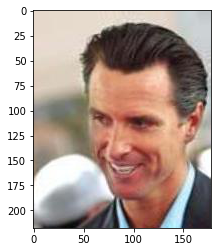

In [ ]:
with h5py.File('mount/My Drive/Colab Notebooks/myo_gan/celeba_dataset/celeba_aligned_small.h5py', 'r') as file_object:
    dataset = file_object['img_align_celeba']
    image = numpy.array(dataset['69.jpg'])
    plt.imshow(image, interpolation='none')
    pass

In [ ]:
image.shape

(218, 178, 3)

In [ ]:
class CelebADataset(Dataset):
    def __init__(self, file):
        self.file_object = h5py.File(file, 'r')
        self.dataset = self.file_object['img_align_celeba']
        pass
    
    def __getitem__(self, index):
        if (index >= len(self.dataset)):
            raise IndexError()
        img = numpy.array(self.dataset[str(index)+'.jpg'])
        return torch.cuda.FloatTensor(img) / 255.0

    def plot_image(self, index):
        plt.imshow(numpy.array(self.dataset[str(index)+'.jpg']), interpolation='nearest')
        pass
    pass

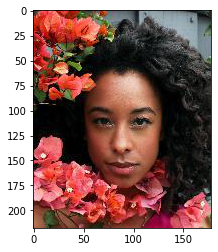

In [ ]:
celeba_dataset = CelebADataset('mount/My Drive/Colab Notebooks/myo_gan/celeba_dataset/celeba_aligned_small.h5py')

celeba_dataset.plot_image(43)

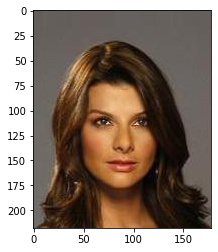

In [ ]:
celeba_dataset.plot_image(33)

In [ ]:
import torch
import torch.nn as nn


In [ ]:
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,
    
    def forward(self, x):
        return x.view(*self.shape)

In [ ]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            View(218*178*3),

            nn.Linear(3*178*218, 100),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(100),

            nn.Linear(100,1),
            nn.Sigmoid()
        )

        self.loss_function = nn.BCELoss()
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
        self.counter = 0
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        return self.model(inputs)


    def train(self, inputs, targets):
        outputs = self.forward(inputs)
        loss = self.loss_function(outputs, targets)

        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass
        
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass

    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

In [ ]:
if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: Tesla T4


device(type='cuda')

In [ ]:
def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data


def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

In [ ]:
x = generate_random_image(2)
print(x.device)

y = generate_random_seed(2)
print(y.device)

cuda:0
cuda:0


In [ ]:
%%time


D = Discriminator()
D.to(device)

for image_data_tensor in celeba_dataset:
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    D.train(generate_random_image((218,178,3)), torch.cuda.FloatTensor([0.0]))
    pass

counter =  1
counter =  2
counter =  3
counter =  4
counter =  5
counter =  6
counter =  7
counter =  8
counter =  9
counter =  10
counter =  11
counter =  12
counter =  13
counter =  14
counter =  15
counter =  32
counter =  33
counter =  34
counter =  35
counter =  36
counter =  37
counter =  38
counter =  39
counter =  40
counter =  41
counter =  42
counter =  43
counter =  44
counter =  45
counter =  46
counter =  47
counter =  64
counter =  65
counter =  66
counter =  67
counter =  68
counter =  69
counter =  70
counter =  71
counter =  72
counter =  73
counter =  74
counter =  75
counter =  76
counter =  77
counter =  78
counter =  79
counter =  96
counter =  97
counter =  98
counter =  99
counter =  100
counter =  101
counter =  102
counter =  103
counter =  104
counter =  105
counter =  106
counter =  107
counter =  108
counter =  109
counter =  110
counter =  111
counter =  128
counter =  129
counter =  130
counter =  131
counter =  132
counter =  133
counter =  134
counter = 

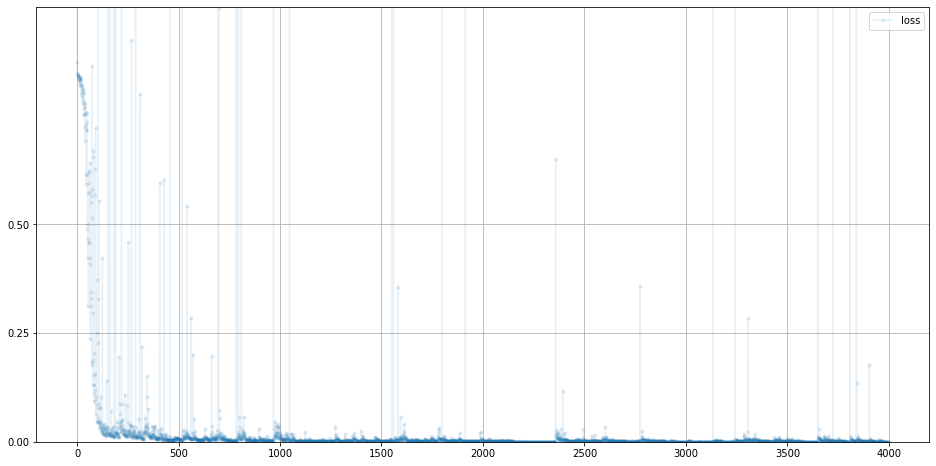

In [ ]:
D.plot_progress()

In [ ]:
class Generator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(100, 3*10*10),
            nn.LeakyReLU(),
            
            nn.LayerNorm(3*10*10),
            
            nn.Linear(3*10*10, 3*218*178),
            
            nn.Sigmoid(),
            View((218,178,3))
        )
        
        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, inputs):        
        # simply run model
        return self.model(inputs)
    
    
    def train(self, D, inputs, targets):
        # calculate the output of the network
        g_output = self.forward(inputs)
        
        # pass onto Discriminator
        d_output = D.forward(g_output)
        
        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

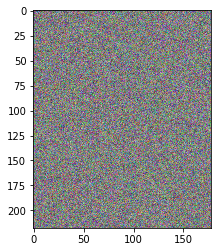

In [ ]:
G = Generator()

G.to(device)

output = G.forward(generate_random_seed(100))
img = output.detach().cpu().numpy()
plt.imshow(img, interpolation='none', cmap='Blues')

In [ ]:
%%time

D = Discriminator()
D.to(device)

G = Generator()
G.to(device)

epochs = 1

for epoch in range(epochs):
    print("epoch = ", epoch + 1)
    
    for image_data_tensor in celeba_dataset:
        D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
        D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))
        G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))
        pass
    pass


epoch =  1
counter =  1
counter =  2
counter =  3
counter =  4
counter =  5
counter =  6
counter =  7
counter =  8
counter =  9
counter =  10
counter =  11
counter =  12
counter =  13
counter =  14
counter =  15
counter =  32
counter =  33
counter =  34
counter =  35
counter =  36
counter =  37
counter =  38
counter =  39
counter =  40
counter =  41
counter =  42
counter =  43
counter =  44
counter =  45
counter =  46
counter =  47
counter =  64
counter =  65
counter =  66
counter =  67
counter =  68
counter =  69
counter =  70
counter =  71
counter =  72
counter =  73
counter =  74
counter =  75
counter =  76
counter =  77
counter =  78
counter =  79
counter =  96
counter =  97
counter =  98
counter =  99
counter =  100
counter =  101
counter =  102
counter =  103
counter =  104
counter =  105
counter =  106
counter =  107
counter =  108
counter =  109
counter =  110
counter =  111
counter =  128
counter =  129
counter =  130
counter =  131
counter =  132
counter =  133
counter =  134

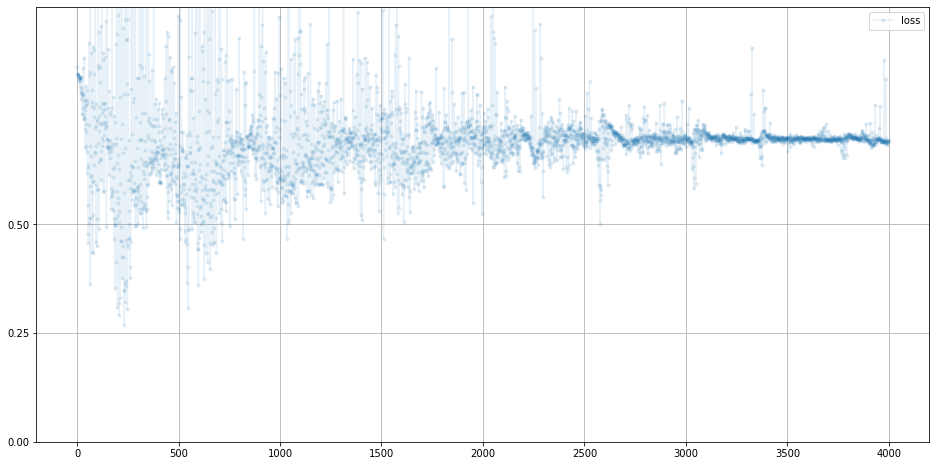

In [ ]:
D.plot_progress()

In [ ]:

G.plot_progress()

NameError: ignored

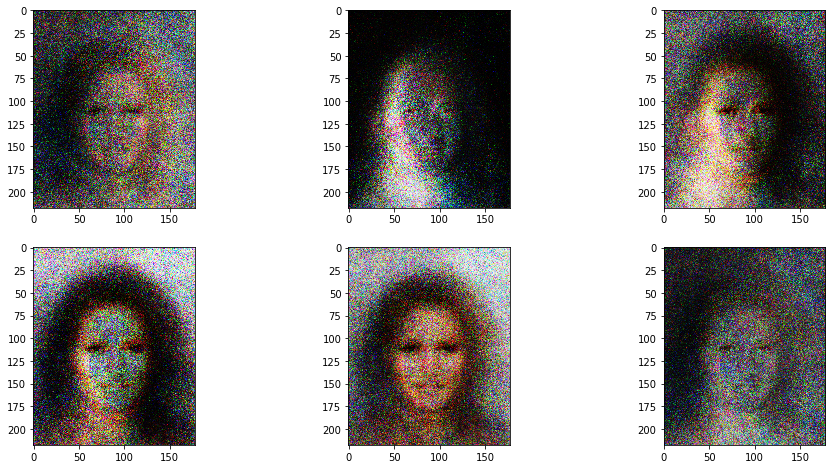

In [ ]:
f, axarr = plt.subplots(2, 3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().cpu().numpy()
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        pass

    pass

In [ ]:
torch.cuda.memory_allocated(device) / (1024*1024*1024)

0.6132516860961914

In [ ]:
torch.cuda.max_memory_allocated(device) / (1024*1024*1024)

1.007251262664795

In [ ]:
print(torch.cuda.memory_summary(device, abbreviated=True))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  643041 KB |    1031 MB |   12310 GB |   12309 GB |
|---------------------------------------------------------------------------|
| Active memory         |  643041 KB |    1031 MB |   12310 GB |   12309 GB |
|---------------------------------------------------------------------------|
| GPU reserved memory   |    1174 MB |    1174 MB |    1174 MB |       0 B  |
|---------------------------------------------------------------